In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# IMDB sentiment Classifier ~ 97% accuracy model - Harshal Gadhe

In [ ]:
def make_df(path):
    df = pd.read_csv(path)
    df = pd.DataFrame(df)
    return df

In [ ]:
df_imdb = make_df("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb.nunique()

In [ ]:
df_imdb.isna().sum()

In [ ]:
df_imdb.info()

In [ ]:
import seaborn as sns

sns.countplot(x = df_imdb['sentiment'])

### Data Visualization using word cloud.

In [ ]:
from sklearn.preprocessing import LabelEncoder

sentences = df_imdb['review']
le = LabelEncoder()
df_imdb['sentiment'] = le.fit_transform(df_imdb['sentiment'])

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# stopwords

stopwords = set(STOPWORDS)

pos=''.join(map(str, sentences[df_imdb['sentiment']==1]))
neg=''.join(map(str, sentences[df_imdb['sentiment']==0]))

wordcloud1 = WordCloud(width = 800, 
                        height = 800, 
                        background_color = 'black', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Pos Senti')
plt.axis('off')

In [ ]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width=800,
                      height=800,
                      background_color='black',
                      stopwords=stopwords,
                      min_font_size=10).generate(neg)

plt.imshow(wordcloud2)
plt.title('neg senti')
plt.axis('off')


### There is a clear visual the 'br br' is used most times. Looking into the df_imdb, there are html inputs. This will affect sentiment analysis as it hold no sentimental value.

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# splitting train-test

labels=to_categorical(df_imdb['sentiment'],num_classes=2)
X_train, X_test, Y_train, Y_test = train_test_split(df_imdb['review'],labels,test_size=0.1,random_state=42)

In [ ]:
# cleaning data, utilizing glove embeddings. For the purpose of misspelling, concated words, or emojis.

glove_embeddings= np.load('/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl',
                          allow_pickle=True)


In [ ]:
# build vocab and count each vocab using function below

def vocab_build(review):
    comments = review.apply(lambda s: s.split()).values
    vocab={}
    
    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab

In [ ]:
# Embedding Coverage. Tells how much % of the words in data are covered by the vocabulary.
# sorted_oov is list of words that needs text cleaning.

def embedding_coverage(review, embeddings):
    
    vocab=vocab_build(review)
    
    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0
    
    for word in vocab:
        try:
            covered[word]=embeddings[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]
            
    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage=covered_num/(covered_num+oov_num)*100
    
    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_word_count, sorted_oov, vocab_coverage, text_coverage

In [ ]:
import operator

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(X_train, glove_embeddings)

test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(X_test, glove_embeddings)

print(f'GloVe embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set')
print(f'GloVe embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in test set')

In [ ]:
# train_oov shows the words that needs preprocessing

train_oov[:10]

In [ ]:
# cleaning sentences.
# this part consist of specific fixes.

import re

def clean_sentences(line):
    
    line=re.sub('<.*?>','',line) # removing html tags
    
    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)
    
    #removing punctuations
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line

In [ ]:
X_train=X_train.apply(lambda s: clean_sentences(s))
X_test=X_test.apply(lambda s: clean_sentences(s))

train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")

test_covered,test_oov,test_vocab_coverage,test_text_coverage=embedding_coverage(X_test,glove_embeddings)
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in training set")

Shown above output, vocabulary % have drastically improved.

In [ ]:
# Using sns to count 10 most used words in training and testing

punctuations = '@#!~?+&*[]-%._-:/£();$=><|{},^' + '''"“´”'`'''
train_word=[]
train_count=[]

i=1
for word, count in train_covered:
    if word not in punctuations:
        train_word.append(word)
        train_count.append(count)
        i+=1
    if(i==15):
        break

In [ ]:
test_word=[]
test_count=[]

i=1
for word, count in test_covered:
    if word not in punctuations:
        test_word.append(word)
        test_count.append(count)
        i+=1
    if(i==15):
        break

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=train_count,y=train_word).set_title('Count of 15 most used in train')
plt.grid()

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=test_count,y=test_word).set_title('Count of 15 most used in test')
plt.grid()

## Preprocessing summary

- NaN value check
- sentiment value count
- wordcloud
- GloVe embeddings + embedding coverage
- Sentence cleaning (too specific example, inefficient)
- Punctuation spacing
- Barplot for most frequent words

# Sentiment Analysis - Cleaning,EDA & BERT(88% Acc) - Madhav Mathur

Install
* Numpy
* Pandas
* Matplotlib
* Fastai


In [2]:
def make_df(url):
    csv = pd.read_csv(url)
    df = pd.DataFrame(csv)
    return df

In [3]:
df_imdb = make_df('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [4]:
df_imdb.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df_imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


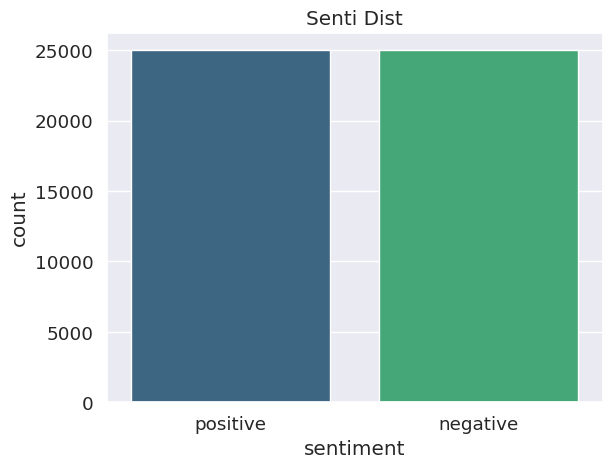

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'darkgrid', font_scale = 1.2)
sns.countplot(data = df_imdb, x='sentiment', palette='viridis')
plt.title('Senti Dist')
plt.show()

In [7]:
df_imdb.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
from nltk.corpus import stopwords
import string
from string import punctuation

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### Basic Data Cleaning

In [9]:
import re
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, features = 'html.parser') #Usage of beautifulSoup
    return soup.get_text()

#squre brackets
def remov_btwn_sqbrkts(text):
    return re.sub('\[[^]]*\]', '', text)
    # \[ matches '['
    # [^]]* matches any char except the ones inside the square brackets. '[' is allowed
    # \] matches ']'
    # Contents in brackets along with the brackets are replaced with empty string.
    
# Removing URL
def remov_url(text):
    return re.sub(r'http\S+', '', text)
    # https is the most common url begginings.
    # \S+ matches one or more non-whitespace chars
    
# Removing the stopwords from txt
def remov_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    # stopwords are like 'the', 'is', etc.
    # strip() turns string into a list of its words. Depending on the method parameter, its split based on that. eg. split(',') ... split by commas
    # for loop iterating over text.split() with 'i'
    # checks if 'i' is in stopwords 'if i.strip().lower() not in stop'
    # Also checks if 'i' is lowercase and alphabelts 'and i.strip().lower().isalpha()'
    
    return " ".join(final_text)

In [10]:
def denoise_text(text):
    text = strip_html(text)
    text = remov_btwn_sqbrkts(text)
    text = remov_url(text)
    text = remov_stopwords(text)
    return text

df_imdb['review'] = df_imdb['review'].apply(denoise_text)

/tmp/ipykernel_42/2673150561.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features = 'html.parser') #Usage of beautifulSoup


In [11]:
df_imdb.sentiment.replace('positive', 1, inplace = True)
df_imdb.sentiment.replace('negative', 0, inplace = True)
df_imdb.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


### WordCloud

In [12]:
sns.set(style = 'white', font_scale = 1.2)

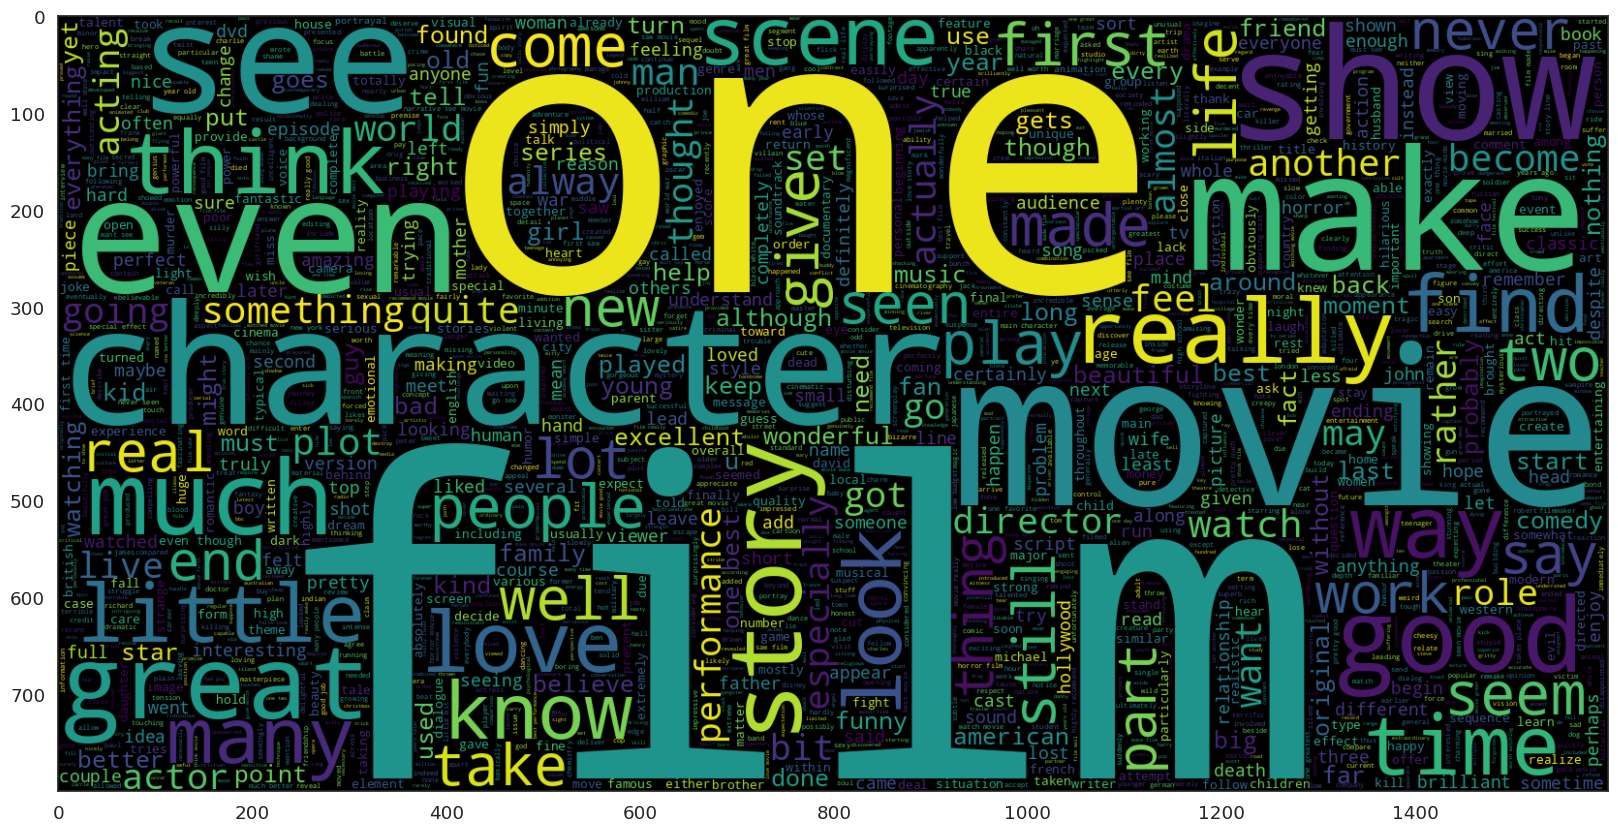

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df_imdb[df_imdb.sentiment == 1].review))

plt.imshow(wc, interpolation = 'bilinear')

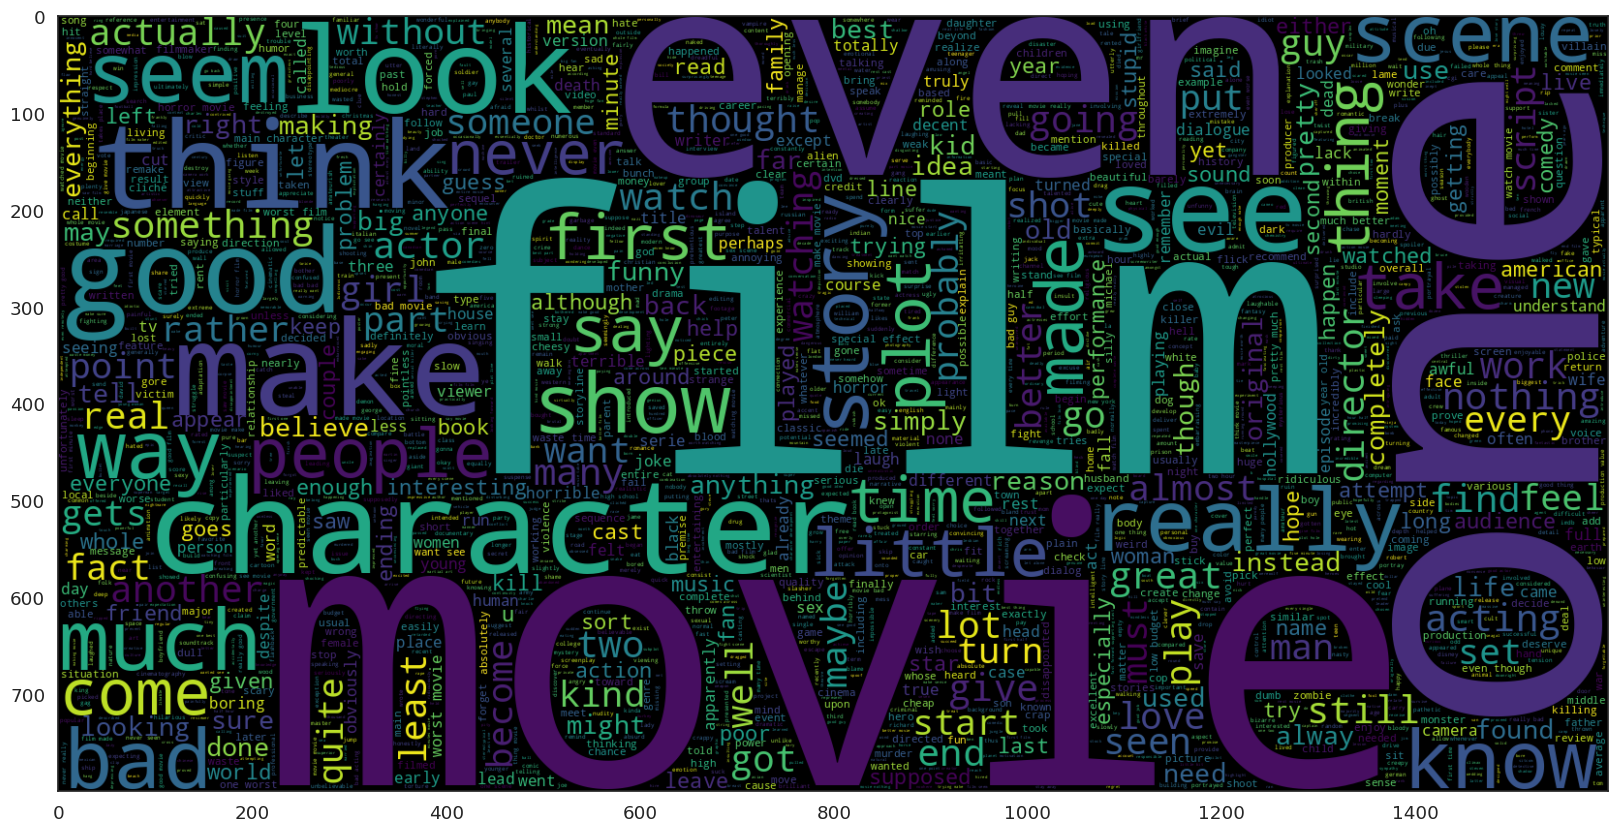

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df_imdb[df_imdb.sentiment == 0].review))

plt.imshow(wc, interpolation = 'bilinear')

### Num of char in txts

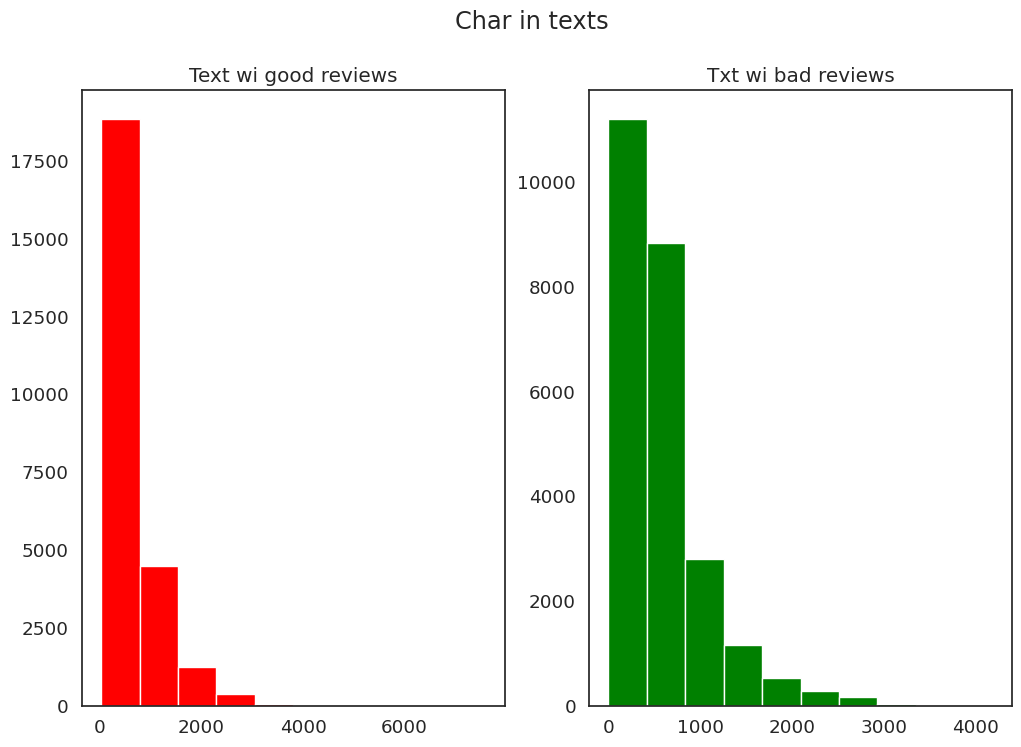

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
text_len = df_imdb[df_imdb['sentiment']==1]['review'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('Text wi good reviews')
text_len = df_imdb[df_imdb['sentiment']==0]['review'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Txt wi bad reviews')
fig.suptitle("Char in texts")
plt.show()

### Num of words in each txt

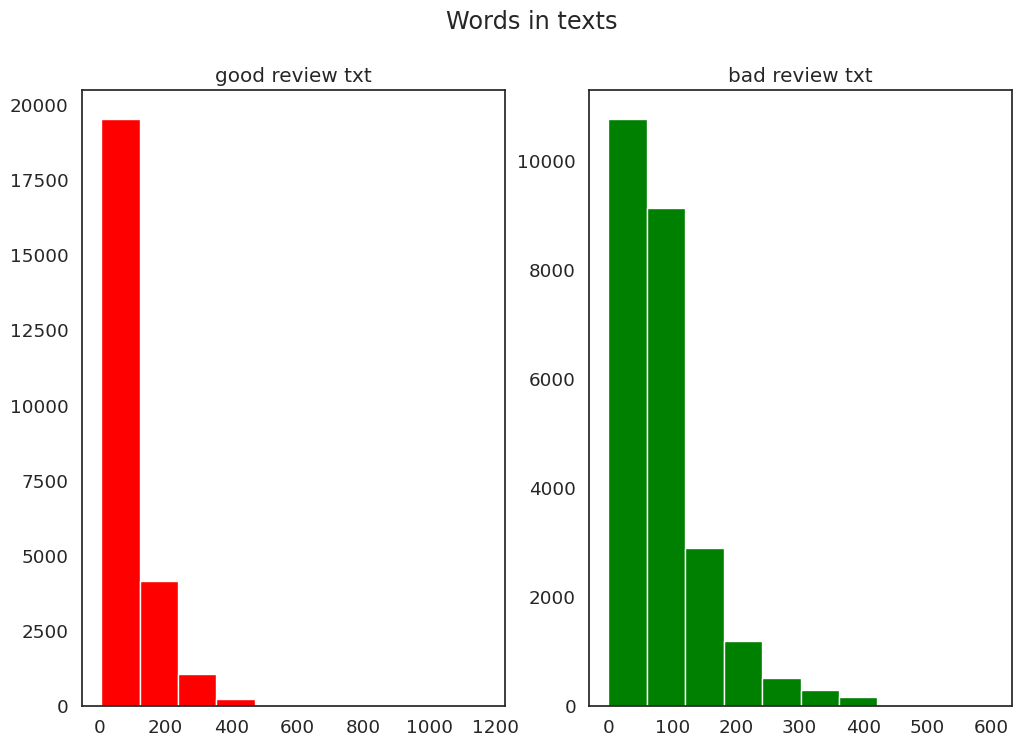

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
text_len = df_imdb[df_imdb['sentiment']==1]['review'].str.split().map(lambda x: len(x))

ax1.hist(text_len, color='red')
ax1.set_title('good review txt')

text_len = df_imdb[df_imdb['sentiment']==0]['review'].str.split().map(lambda x:len(x))

ax2.hist(text_len, color='green')
ax2.set_title('bad review txt')

fig.suptitle('Words in texts')
plt.show()

### Avg word length in a text

/tmp/ipykernel_42/991214060.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_42/991214060.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level fu

Text(0.5, 0.98, 'Avg word len in each txt')

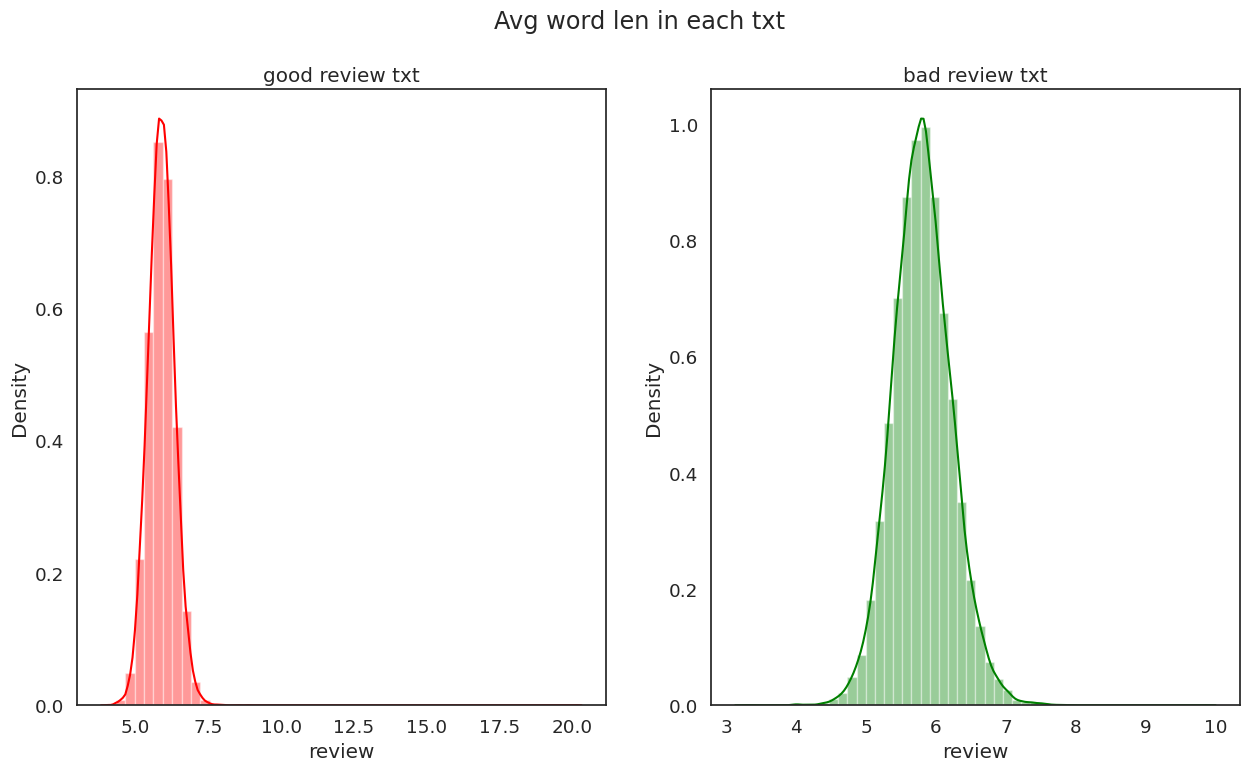

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,8))
word = df_imdb[df_imdb['sentiment']==1]['review'].str.split().apply(lambda x: [len(i) for i in x])

sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('good review txt')

word = df_imdb[df_imdb['sentiment']==0]['review'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('bad review txt')

fig.suptitle('Avg word len in each txt')

In [18]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = get_corpus(df_imdb.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [19]:
from collections import Counter 
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 61492,
 'film': 55087,
 'one': 45065,
 'like': 37301,
 'would': 23813,
 'even': 23718,
 'good': 23475,
 'really': 21806,
 'see': 20905,
 'get': 17691}

In [20]:
def get_toptxt_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq = worted(words_frq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Above is for common words, bigram, trigram analysis. Will skip to BERT

# BERT working

* Token embeddings
* Segment embeddings
* Positional embeddings

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_imdb.review, df_imdb.sentiment, random_state=42, stratify = df_imdb.sentiment)

In [22]:
pip install huggingface-cli

  Obtaining dependency information for huggingface-cli from https://files.pythonhosted.org/packages/51/48/c733bc6edcf815b7a6d98e96a07c2ca9c2affd105eb012c6acbd4b4a5313/huggingface_cli-0.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [26]:
# fast encoding

from tokenizers import BertWordPieceTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import transformers

#load in DistilBert
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased', lower = True)

#save the loaded tokenizer locally
tokenizer.save_pretrained('.')

#reload with HF tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [27]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):
    
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
        
    return np.array(all_ids)

In [28]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)

In [40]:
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [41]:
import torch

bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [42]:
model = build_model(bert_model, max_len=400)
model.summary()

In [ ]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)